## Notes:
Filtering with timeframe LDA doesn't affect anything

TODO:
- Equalization
- CAR
- Bayesian LDA
- TVLDA

In [2]:
!pip install mne

In [1]:
import os
import numpy as np
import mne
from mne.externals.pymatreader import read_mat
import scipy.signal as sig
import matplotlib.pyplot as plt

In [2]:
raw = read_mat(
    "/home/malyshev/Projects/hackthat-p300/data/S1.mat"
)
fs = 250
raw["info"] = mne.create_info(["1","2","3","4","5","6","7","8"], 250)

In [6]:
trig = raw['trig']
data = raw['y']

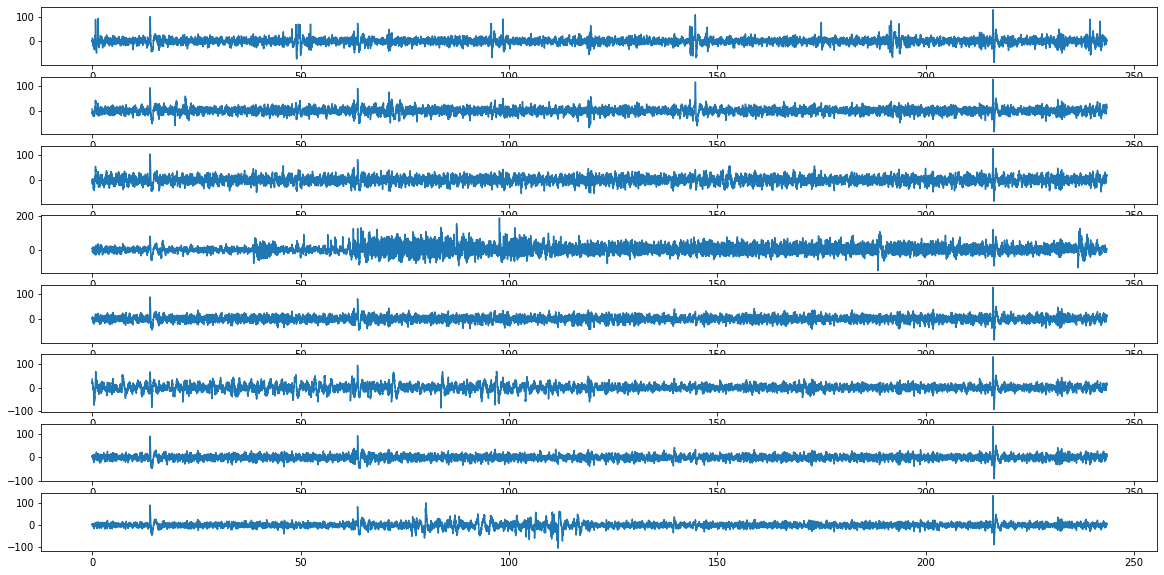

In [7]:
def plot_signal(signals: np.ndarray, sep=False):
    plt.figure(figsize=[20,10])
    N = signals.shape[0]
    for i in range(signals.shape[1]):
        if sep:
            plt.subplot(8,1,i+1)
        plt.plot(np.linspace(0,N/fs,N),signals[:,i])
    plt.show()

plot_signal(data, True)

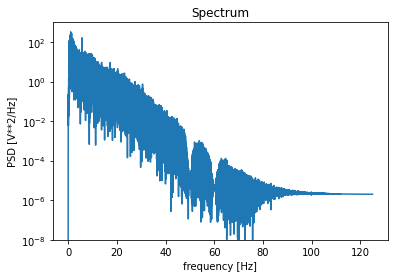

In [8]:
f, Pxx_den = sig.periodogram(data[:,0], fs)
plt.semilogy(f, Pxx_den)
plt.ylim([1e-8, 1e3])
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.title('Spectrum')
plt.show()

## Filter and preview

In [9]:
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = sig.butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = sig.lfilter(b, a, data)
    return y

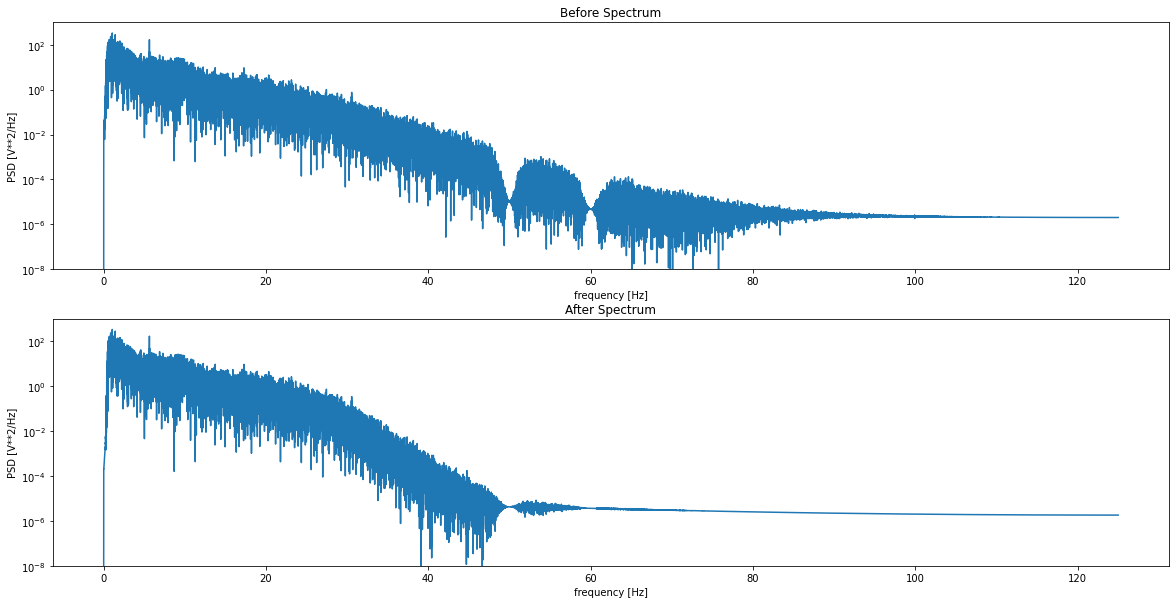

In [11]:
plt.figure(figsize=(20,10))
plt.subplot(2,1,1)
plt.semilogy(*sig.periodogram(data[:,0], fs))
plt.ylim([1e-8, 1e3])
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.title('Before Spectrum')


plt.subplot(2,1,2)
plt.semilogy(*sig.periodogram(butter_bandpass_filter(data[:,0],0.5,30,fs), fs))
plt.ylim([1e-8, 1e3])
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.title('After Spectrum')
plt.show()

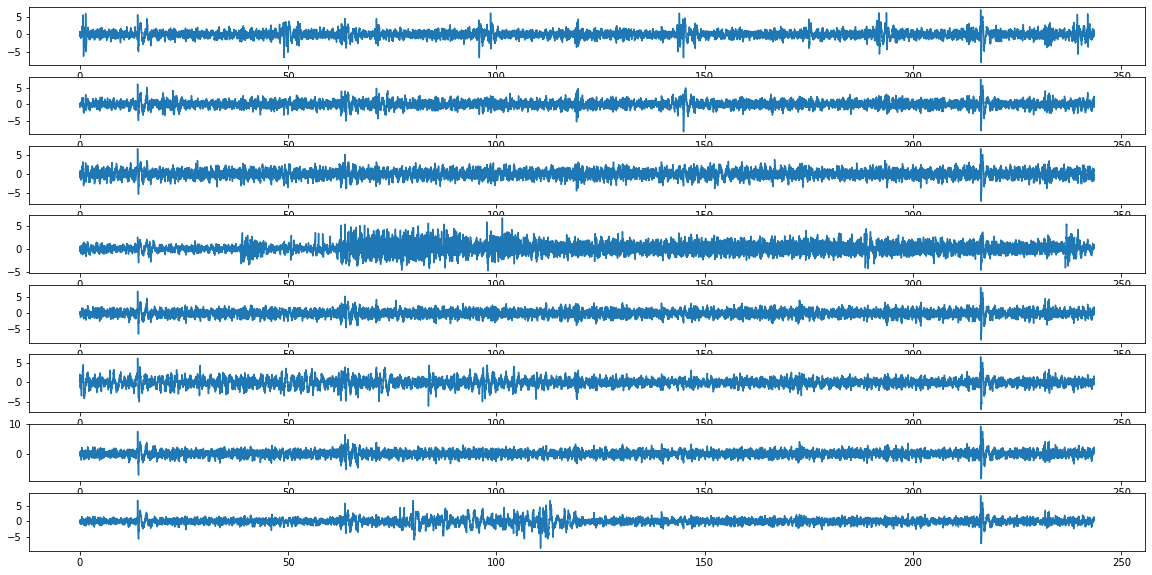

In [12]:
filtered = data.copy()
for i in range(filtered.shape[1]):
    filtered[:,i] = butter_bandpass_filter(data[:,i], 0.5, 30, fs)
filtered = (filtered - filtered.mean(0)[None]) / filtered.std(0)[None]
plot_signal(filtered, True)

## Show near label

75


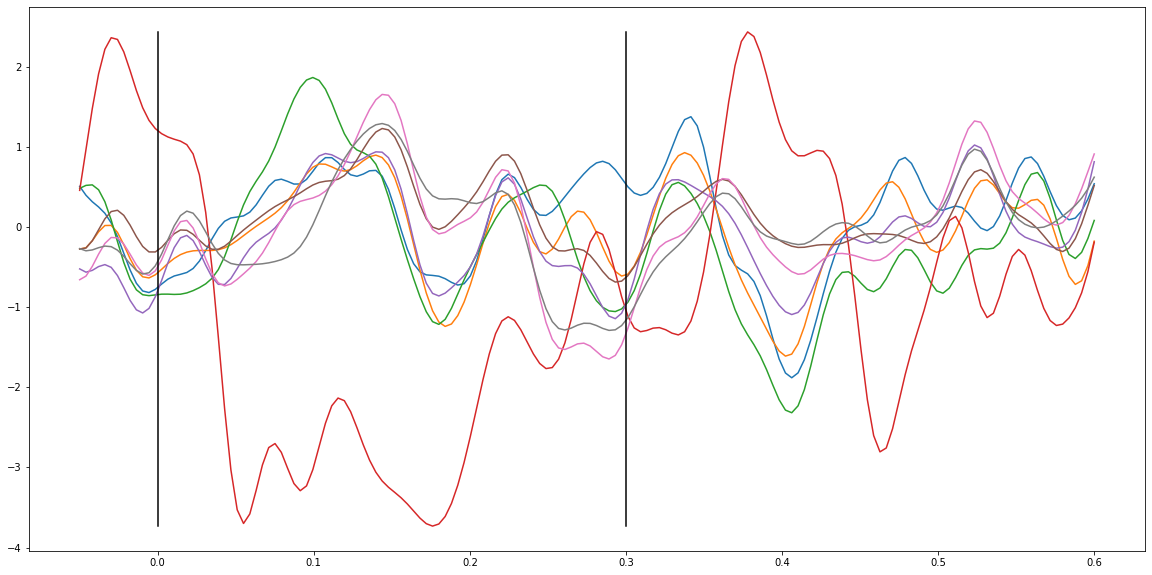

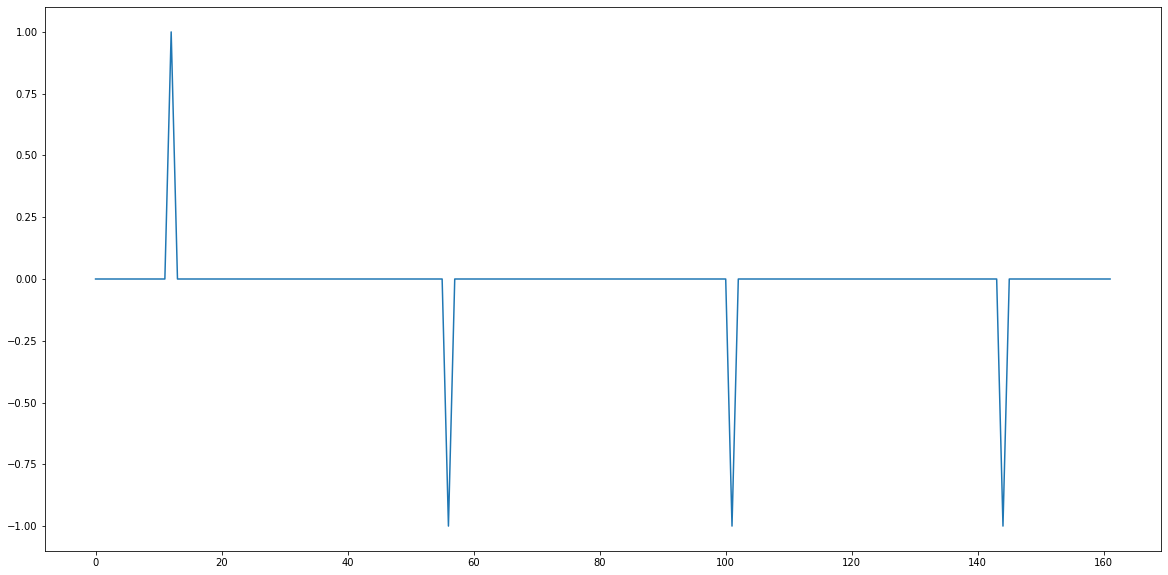

In [13]:
last = np.where(trig == 1)[0][-1]
p300 = int(0.3 * fs)
before = int(0.05 * fs)
print(p300)
plt.figure(figsize=(20,10))
sec = filtered[last-before:last + p300*2]
plt.plot(np.linspace(-0.05,0.3*2,sec.shape[0]),sec)
plt.plot([0.0]*2, [sec.min(), sec.max()], c='black')
plt.plot([0.3]*2, [sec.min(), sec.max()], c='black')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(trig[last-before:last + p300*2])
plt.show()

### Classification

In [14]:
from sklearn.discriminant_analysis import *
from sklearn.decomposition import PCA

In [61]:
y = []
xs = []
for i in np.where(trig != 0)[0]:
    xs.append(filtered[i-before:i+p300*2])
    y.append((trig[i]+1) / 2)
y = np.array(y)
X = np.stack(xs)

In [78]:
filtered = data

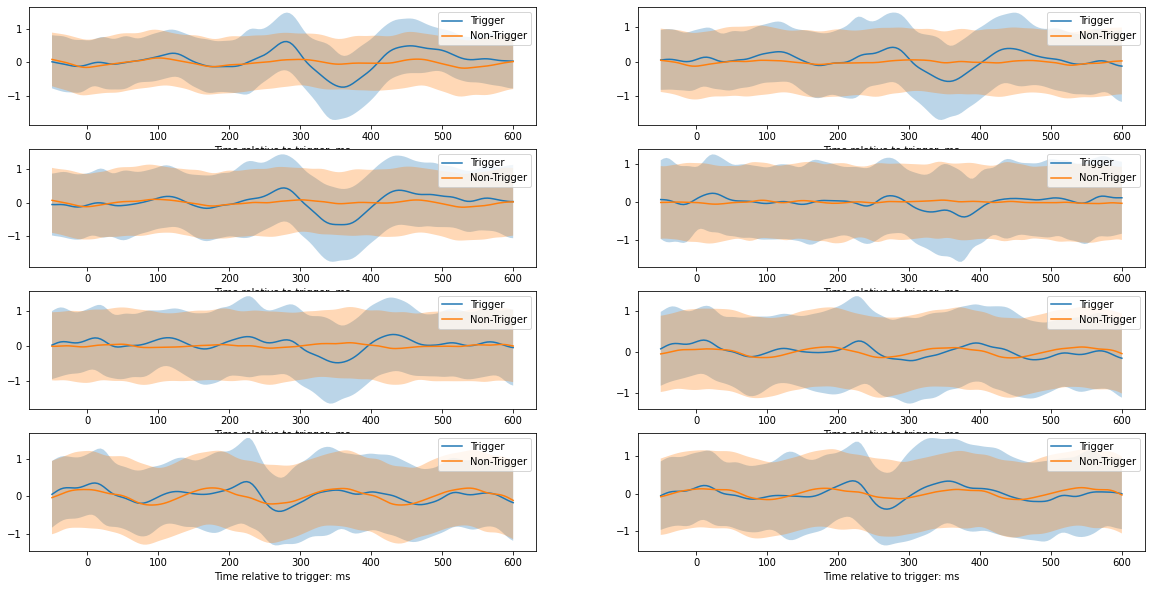

In [79]:
plt.figure(figsize=(20,10))
t = np.linspace(-50,600,X.shape[1])
for i in range(8):
    plt.subplot(4,2,i+1)
    mean = X[y==1,:,i].mean(0)
    std = X[y==1,:,i].std(0)
    plt.plot(t,mean, label='Trigger')
    plt.fill_between(t,mean-std, mean+std, alpha=0.3)
    mean = X[y==0,:,i].mean(0)
    std = X[y==0,:,i].std(0)
    plt.plot(t,mean, label='Non-Trigger')
    plt.fill_between(t,mean-std, mean+std, alpha=0.3)
    plt.legend()
    plt.xlabel('Time relative to trigger: ms')
plt.show()

[0.11511789 0.09282197 0.05575301 0.04975647 0.04450789 0.04356855
 0.02756402 0.02595714]


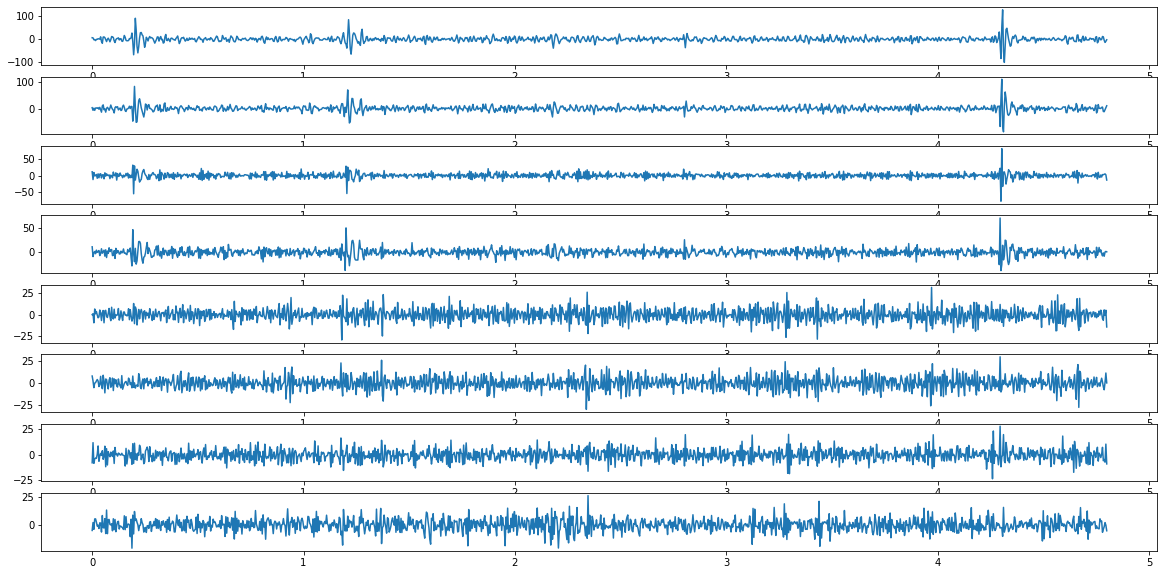

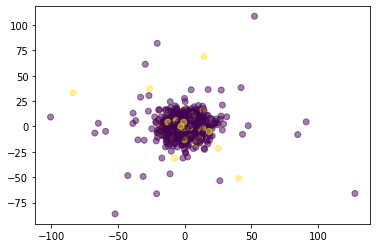

In [80]:
pca = PCA(n_components=8)
X_flat = X.reshape((X.shape[0],-1))
transformed = pca.fit_transform(X_flat)
print(pca.explained_variance_ratio_)
plot_signal(transformed, True)
plt.scatter(transformed[:,0], transformed[:,1],alpha=0.5, c=y)

0.9983333333333333


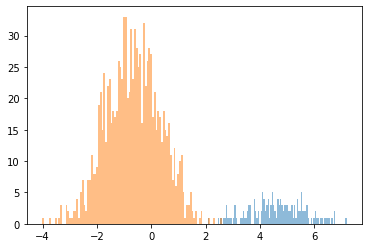

In [81]:
lda = LinearDiscriminantAnalysis()
res = lda.fit_transform(X_flat, y)
print(lda.score(X_flat, y))
plt.hist(res[y==1],bins=100,alpha=0.5)
plt.hist(res[y==0],bins=100,alpha=0.5)
plt.show()

In [82]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
model = LinearDiscriminantAnalysis()
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
scores = cross_val_score(model, X_flat, y, scoring='accuracy', cv=cv, n_jobs=-1)
print('Mean Accuracy: %.3f (%.3f)' % (scores.mean(), scores.std()))
print('Data split: %.3f' % max(1 - y.mean(),y.mean()))

Mean Accuracy: 0.882 (0.027)
Data split: 0.875
